In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [129]:
control = pd.read_csv('task_2_history_control.csv')
old_ab = pd.read_csv('task_2_history_old_ab.csv')
results = pd.read_csv('task_2_results.csv')

In [130]:
control.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  100000 non-null  str  
 1   clicks   100000 non-null  int64
 2   views    100000 non-null  int64
dtypes: int64(2), str(1)
memory usage: 2.3 MB


In [143]:
control_clicks = control['clicks'].sum()
control_views = control['views'].sum()

In [145]:
p_A = control_clicks / control_views
p_B = p_A * 1.10

In [148]:
alpha = 0.05
power = 0.80
r = 0.1
Z_alpha = stats.norm.ppf(1 - alpha/2)
Z_beta = stats.norm.ppf(power)

In [150]:
n_B = (Z_alpha + Z_beta) ** 2 * (p_A * (1 - p_A) / r + p_B * (1 - p_B)) / (p_B - p_A) ** 2
n_A = n_B / r
n_total = n_A + n_B

print(f"Базовый CTR: {p_A:.1%}")
print(f"Ожидаемый CTR тест: {p_B:.1%}")
print(f"Размер тестовой группы: {n_B:.0f} юзеров")
print(f"Размер контрольной: {n_A:.0f} юзеров")
print(f"Общая выборка: {n_total:.0f} юзеров")

Базовый CTR: 30.0%
Ожидаемый CTR тест: 33.0%
Размер тестовой группы: 20203 юзеров
Размер контрольной: 202031 юзеров
Общая выборка: 222234 юзеров


In [131]:
old_ab.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  100000 non-null  str  
 1   clicks   100000 non-null  int64
 2   views    100000 non-null  int64
dtypes: int64(2), str(1)
memory usage: 2.3 MB


In [132]:
results.info()

<class 'pandas.DataFrame'>
RangeIndex: 4444 entries, 0 to 4443
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  4444 non-null   str  
 1   clicks   4444 non-null   int64
 2   views    4444 non-null   int64
 3   group    4444 non-null   str  
dtypes: int64(2), str(2)
memory usage: 139.0 KB


In [133]:
results['CTR'] = results['clicks'] / results['views'] * 100

In [134]:
results = results.groupby('group').agg({
    'clicks': 'sum',
    'views': 'sum',
    'CTR': 'mean'
}).reset_index()

results

,group,clicks,views,CTR
0,A,11067,35649,30.559828
1,B,1171,3585,33.136797


In [135]:
df = pd.DataFrame({'group': ['control', 'old_ab'], 
                   'CTR': [control['clicks'].sum() / control['views'].sum() * 100,
                           old_ab['clicks'].sum() / old_ab['views'].sum() * 100]})

In [136]:
df

,group,CTR
0,control,30.040501
1,old_ab,25.562424


In [137]:
def diff(test: float, control: float):
    return (test - control) / control * 100

In [138]:
old_ab_ctr = df[df['group'] == 'old_ab']['CTR'].iloc[0]
control_ctr = df[df['group'] == 'control']['CTR'].iloc[0]

print(f"old CTR: {round(diff(old_ab_ctr, control_ctr))}%")
print(f"CTR: {round(diff(results[results['group'] == 'B']['CTR'].iloc[0], results[results['group'] == 'A']['CTR'].iloc[0]))}%")

old CTR: -15%
CTR: 8%


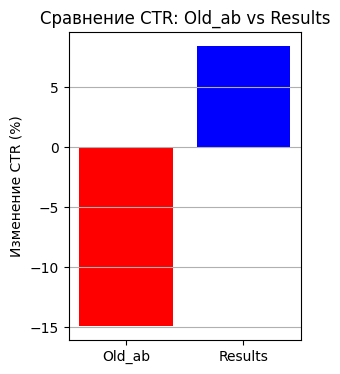

In [151]:
plt.figure(figsize=(3, 4))
plt.bar(['Old_ab', 'Results'], 
        [diff(old_ab_ctr, control_ctr), 
         diff(results[results['group'] == 'B']['CTR'].iloc[0], results[results['group'] == 'A']['CTR'].iloc[0])], 
        color=['red', 'blue'])
plt.ylabel('Изменение CTR (%)')
plt.title('Сравнение CTR: Old_ab vs Results')
plt.grid(axis='y')
plt.show()

In [139]:
cont_table = [[results[results['group'] == 'A']['clicks'].iloc[0], 
               results[results['group'] == 'A']['views'].iloc[0] - results[results['group'] == 'A']['clicks'].iloc[0]],
              [results[results['group'] == 'B']['clicks'].iloc[0], 
               results[results['group'] == 'B']['views'].iloc[0] - results[results['group'] == 'B']['clicks'].iloc[0]]
              ]

In [140]:
chi2, p_value, dof, expected = stats.chi2_contingency(cont_table)

print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Результат статистически значим")
else:
    print("Результат не значим")

p-value: 0.0481
Результат статистически значим


**Вывод:**

*Расчёт размера выборки прошёл успешно.  
Новый A/B-тест показал статистически значимый рост CTR (p-value = 0.0481 < 0.05), восстановив метрику после провала предыдущего теста (-15%).*